In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
import numpy as np
import cv2
import zipfile
import os
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/Applied_ML_Project_data/7000_Balanced_Chest_data_1/tenK_balanced.zip' # copy to your drive folder
extract_path = '/content/dataPath/7_thousand_imgs'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [3]:
# List files in the extraction path
new_extract_path = os.path.join(extract_path, "tenK_balanced")
file_list = os.listdir(new_extract_path)
print(len(file_list))
extract_path = new_extract_path

7989


In [4]:
if os.path.exists(extract_path + "/selected_images_classes.csv"):
  print(True)
  os.remove(extract_path + "/selected_images_classes.csv")

True


In [5]:
file_list = os.listdir(extract_path)
print(len(file_list))

7988


In [6]:
all_labels_path = '/content/drive/My Drive/Applied_ML_Project_data/7000_Balanced_Chest_data_1/selected_images_classes.csv'
# Step 1: Load All the Labels
labels_df = pd.read_csv(all_labels_path)

In [7]:
labels_df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_001.png,Cardiomegaly|Emphysema
3,00000001_002.png,Cardiomegaly|Effusion
4,00000001_002.png,Cardiomegaly|Effusion


In [8]:
all_image_names = labels_df['Image Index']

In [9]:
#print(all_image_names)

In [10]:
all_image_names_set = set(all_image_names)
len(all_image_names_set)

7988

In [11]:
unique_labels_df = labels_df.drop_duplicates(subset='Image Index', keep='first')


In [12]:
unique_labels_df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
3,00000001_002.png,Cardiomegaly|Effusion
5,00000002_000.png,No Finding
6,00000003_001.png,Hernia


In [13]:
len(unique_labels_df["Image Index"])

7988

In [14]:
# Now use image names as index, and assign labels and

In [15]:
data_pd = unique_labels_df
# .drop(columns=[ 'Height', 'OriginalImage_Width','OriginalImagePixelSpacing_x' , 'y', 'Patient ID'], errors='ignore')
# data_pd = data_pd.drop(columns=['Follow-up #', 'Patient Age', 'Patient Gender', 'View Position'],  errors='ignore')

In [16]:
data_pd.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
3,00000001_002.png,Cardiomegaly|Effusion
5,00000002_000.png,No Finding
6,00000003_001.png,Hernia


In [17]:
labels_dict = {image_name: idx for idx, image_name in enumerate(data_pd['Image Index'])}

In [18]:
#labels_dict

In [19]:
diseases = ['Cardiomegaly', 'Pneumothorax', 'No Finding', 'Effusion', 'Emphysema', 'Hernia']
data_pd2 = data_pd
for disease in diseases:
  data_pd2[disease] = [disease in i  for i in  data_pd['Finding Labels']]
data_pd2 = data_pd2.drop(columns=['Finding Labels'])

<ipython-input-19-9a321521e8a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd2[disease] = [disease in i  for i in  data_pd['Finding Labels']]
<ipython-input-19-9a321521e8a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd2[disease] = [disease in i  for i in  data_pd['Finding Labels']]
<ipython-input-19-9a321521e8a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [20]:
data_pd2.head()

,Image Index,Cardiomegaly,Pneumothorax,No Finding,Effusion,Emphysema,Hernia
0,00000001_000.png,True,False,False,False,False,False
1,00000001_001.png,True,False,False,False,True,False
3,00000001_002.png,True,False,False,True,False,False
5,00000002_000.png,False,False,True,False,False,False
6,00000003_001.png,False,False,False,False,False,True


In [21]:
data_pd3 = data_pd2

In [22]:
data_pd3['Image Index'] = data_pd3['Image Index'].map(labels_dict)
data_pd3.head()

,Image Index,Cardiomegaly,Pneumothorax,No Finding,Effusion,Emphysema,Hernia
0,0,True,False,False,False,False,False
1,1,True,False,False,False,True,False
3,2,True,False,False,True,False,False
5,3,False,False,True,False,False,False
6,4,False,False,False,False,False,True


In [23]:
# Replace 'True' with 1 and 'False' with 0
data_pd3.replace({True: 1, False: 0}, inplace=True)
data_pd3.head()

,Image Index,Cardiomegaly,Pneumothorax,No Finding,Effusion,Emphysema,Hernia
0,0,1,0,0,0,0,0
1,1,1,0,0,0,1,0
3,2,1,0,0,1,0,0
5,3,0,0,1,0,0,0
6,4,0,0,0,0,0,1


In [24]:
# Set the first column as the index
data_pd3.set_index(data_pd3.columns[0], inplace=True)

In [25]:
data_pd3.head()

,Cardiomegaly,Pneumothorax,No Finding,Effusion,Emphysema,Hernia
Image Index,,,,,,
0,1,0,0,0,0,0
1,1,0,0,0,1,0
2,1,0,0,1,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,1


In [26]:
data_pd3.loc[1]

Cardiomegaly    1
Pneumothorax    0
No Finding      0
Effusion        0
Emphysema       1
Hernia          0
Name: 1, dtype: int64

In [27]:
from torch.utils.data import Dataset
from PIL import Image
import cv2

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, labels_dict, df3, transform=None):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.labels_dict = labels_dict
        self.transform = transform
        self.df3 = df3

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Debugging line
        # print("Filename:", self.file_list[idx])
        if self.file_list[idx] not in self.labels_dict:
            print("Filename not found in labels_dict")
        # Query the DataFrame by the index (here, 'index_value' is the value you want to query)
        label = torch.tensor(self.df3.loc[self.labels_dict[self.file_list[idx]]], dtype=torch.float32)
        #print(len(label))
        return image, label

In [28]:
from scipy import ndimage
class GaussianLaplaceTransform:
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, img):
        # Convert PIL Image to numpy array
        original_img = np.array(img)

        # Apply Gaussian Laplace filter
        xray_LG = ndimage.gaussian_laplace(original_img, sigma=self.sigma)

        # Convert back to PIL Image
        result_img = Image.fromarray(xray_LG)

        return result_img

class GaussianGradientTransform:
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, img):
        # Convert PIL Image to numpy array
        original_img = np.array(img)

        # Apply Gaussian Laplace filter
        x_ray_image_gaussian_gradient = ndimage.gaussian_gradient_magnitude(original_img, sigma=self.sigma)

        # Convert back to PIL Image
        result_img = Image.fromarray(x_ray_image_gaussian_gradient)

        return result_img

In [29]:
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # need to change this later

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    GaussianLaplaceTransform(sigma=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#extract_path = '/content/dataPath/thousand_imgs'
#extract_path = '/content/dataPath/5_thousand_imgs'
custom_dataset = CustomImageDataset(root_dir=extract_path, labels_dict = labels_dict, df3=data_pd3, transform=transform)

In [30]:
print(len(custom_dataset))
print(type(custom_dataset))

7988
<class '__main__.CustomImageDataset'>


In [31]:
# Split the dataset into training and testing sets (60-20-20 split)
train_dataset, test_dataset = train_test_split(custom_dataset, test_size=0.2, random_state=42)
#train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.25, random_state=42)
val_dataset = test_dataset


In [32]:
# Create DataLoader instances for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(len(train_dataset))

6390


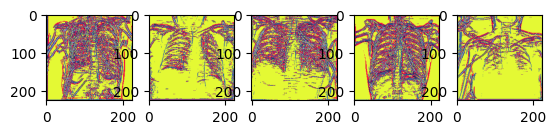

In [33]:
f, axarr = plt.subplots(1,5)
toPIL = transforms.ToPILImage()
axarr[0].imshow(toPIL(train_dataset[0][0]))
axarr[1].imshow(toPIL(train_dataset[1][0]))
axarr[2].imshow(toPIL(train_dataset[2][0]))
axarr[3].imshow(toPIL(train_dataset[3][0]))
axarr[4].imshow(toPIL(train_dataset[4][0]))

In [34]:
# Function to Unfreeze a Specific Number of Layers from the End
def unfreeze_layers(model, num_layers_to_unfreeze):
    child_counter = 0
    children_list = list(model.children())
    num_children = len(children_list)

    # Reverse the children list to start from the last layer
    children_list = list(reversed(children_list))

    # Unfreeze layers from the end
    for child in children_list:
        if child_counter < num_layers_to_unfreeze:
            for param in child.parameters():
                param.requires_grad = True
            child_counter += 1
        else:
            break


# Function to Load and Modify ResNet-18
def load_resnet101(num_classes, num_unfrozen_layers):
    model = models.resnet101(pretrained=True)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the specified number of layers from the end
    unfreeze_layers(model, num_unfrozen_layers)

    # Modify the final fully connected layer

    model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes)
    )

    return model


In [35]:
# Training Function with Early Stopping
train_losses = []
val_losses = []

def train_model(model, dataloaders, criterion, weighted_criterion, optimizer, train_dataset, num_epochs=5, save_model=0):
    saved_pts = {}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on device: {device}")  # Print the device information
    model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        dataloaders['train'] = DataLoader(train_dataset, batch_size=64, shuffle=True)

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = weighted_criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        average_train_loss = train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        if save_model:
          model_path = 'saved_model_dict_' + str(epoch) + '.pth'

          if epoch in [4, 7, 9]:
            torch.save(model.state_dict(), model_path)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = weighted_criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(dataloaders['val'])
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        val_losses.append(val_loss)

    print('Training complete')
    return model


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(diseases)
freq = np.zeros(num_classes)

for _, freq_labels_batch in train_dataloader:
    for col1 in range(num_classes):
        class_count = freq_labels_batch[:, col1].sum().item()
        freq[col1] += class_count

total_samples = np.sum(freq)
class_weights = [total_samples / (len(freq) * freq_val) for freq_val in freq]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [37]:
# Normalize class weights to sum up to 1.0
class_weights /= class_weights.sum()
class_weights = class_weights.to(device)

In [38]:
# Setup for Training with Variable Learning Rate and Layers
# n_classes = len(unique_train_classes)  # Replace with your number of classes
num_unfrozen_layers = 5  # Choose the number of layers to unfreeze
learning_rate = 0.00003    # Set your learning rate
num_classes = len(diseases)
n_classes = num_classes
#print(n_classes)
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
model_ft = load_resnet101(num_classes, num_unfrozen_layers)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=learning_rate)
#optimizer_ft = optim.Adam(model.fc.parameters(), lr=learning_rate)  # Optimizer for the final layer
criterion = nn.BCEWithLogitsLoss()  # Golden criterion.
#Trying using class weightage techniques to avoid class imbalance issues
weighted_criterion = nn.BCEWithLogitsLoss(weight=class_weights)

num_epochs = 8
early_stopping_patience = 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:04<00:00, 44.5MB/s]


In [39]:
for name, param in model_ft.named_parameters():
    print(f'Parameter: {name}, requires_grad: {param.requires_grad}')

Parameter: conv1.weight, requires_grad: False
Parameter: bn1.weight, requires_grad: False
Parameter: bn1.bias, requires_grad: False
Parameter: layer1.0.conv1.weight, requires_grad: False
Parameter: layer1.0.bn1.weight, requires_grad: False
Parameter: layer1.0.bn1.bias, requires_grad: False
Parameter: layer1.0.conv2.weight, requires_grad: False
Parameter: layer1.0.bn2.weight, requires_grad: False
Parameter: layer1.0.bn2.bias, requires_grad: False
Parameter: layer1.0.conv3.weight, requires_grad: False
Parameter: layer1.0.bn3.weight, requires_grad: False
Parameter: layer1.0.bn3.bias, requires_grad: False
Parameter: layer1.0.downsample.0.weight, requires_grad: False
Parameter: layer1.0.downsample.1.weight, requires_grad: False
Parameter: layer1.0.downsample.1.bias, requires_grad: False
Parameter: layer1.1.conv1.weight, requires_grad: False
Parameter: layer1.1.bn1.weight, requires_grad: False
Parameter: layer1.1.bn1.bias, requires_grad: False
Parameter: layer1.1.conv2.weight, requires_grad:

In [40]:
start_time = time.time()
model_ft = train_model(model_ft, dataloaders, criterion, weighted_criterion, optimizer_ft, train_dataset, num_epochs=num_epochs, save_model=0)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Running on device: cuda
Epoch 1/8, Training Loss: 0.0266, Validation Loss: 0.0435
Epoch 2/8, Training Loss: 0.0170, Validation Loss: 0.0395
Epoch 3/8, Training Loss: 0.0111, Validation Loss: 0.0399
Epoch 4/8, Training Loss: 0.0056, Validation Loss: 0.0432
Epoch 5/8, Training Loss: 0.0024, Validation Loss: 0.0450
Epoch 6/8, Training Loss: 0.0015, Validation Loss: 0.0450
Epoch 7/8, Training Loss: 0.0011, Validation Loss: 0.0476
Epoch 8/8, Training Loss: 0.0007, Validation Loss: 0.0487
Training complete
Elapsed time: 804.8369793891907 seconds


8


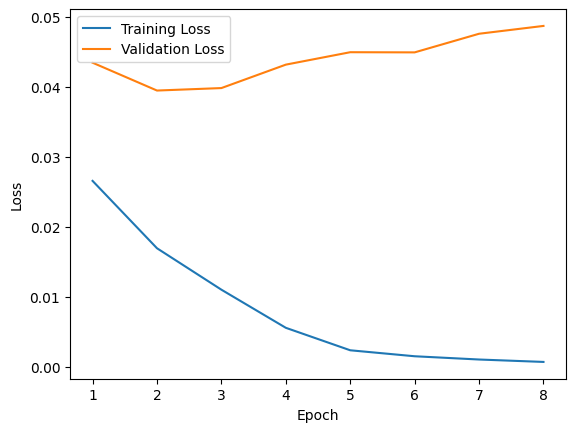

In [41]:
print(len(train_losses))
# Plot the training curve
num_epochs_run = len(train_losses)
plt.plot(range(1, num_epochs_run + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs_run + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(model, test_dataloader, device, threshold):
  # Set the model to evaluation mode
  model.eval()

  # Lists to store true labels and predicted labels
  true_labels = []
  predicted_labels = []
  predicted_proba = []

  with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(torch.float32).to(device)
          outputs = torch.sigmoid(model(images))
          #breakpoint()
          predicted_batch = (outputs > threshold).float()

          # Append true and predicted labels
          true_labels.append(labels.to('cpu'))
          predicted_labels.append(predicted_batch.to('cpu'))
          predicted_proba.append(outputs.to('cpu'))

  # Concatenate the lists to create numpy arrays
  true_labels = torch.cat(true_labels, dim=0)
  predicted_labels = torch.cat(predicted_labels, dim=0)
  predicted_proba = torch.cat(predicted_proba, dim = 0)

  # Calculate accuracy, precision, recall, and F1 score
  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average='micro')
  recall = recall_score(true_labels, predicted_labels, average='micro')
  f1 = f1_score(true_labels, predicted_labels, average='micro')

  # Print the metrics
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  return true_labels, predicted_labels, predicted_proba

In [43]:
# Calculate and visualize the confusion matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from itertools import cycle

def print_confusion(true_labels, predicted_labels):
  # Calculate and visualize the multi-label confusion matrix
  mcm = multilabel_confusion_matrix(true_labels, predicted_labels)
  print("Multi-label Confusion Matrix:")
  #print(mcm)

  # Plot confusion matrices
  fig, axes = plt.subplots(2, 3, figsize=(15, 6))
  class_names = diseases

  for i in range(num_classes):
      ax = axes[i // 3, i % 3]
      sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
      ax.set_xlabel('Predicted')
      ax.set_ylabel('True')
      ax.set_title(class_names[i])

  plt.tight_layout()
  plt.show()

  # Print other classification metrics
  print("\nClassification Report:")
  print(classification_report(true_labels, predicted_labels, target_names=class_names))

def print_ROC(true_labels, predicted_proba):

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  class_names = diseases

  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_proba[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plotting individual ROC curves
  plt.figure(figsize=(15, 6))

  colors = cycle(['aqua', 'darkorange', 'blue', 'red', 'green', 'brown'])
  for i, color in zip(range(num_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(diseases[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic for each class')
  plt.legend(loc="lower right")
  plt.show()

def print_PR_curve(true_labels,  predicted_proba):
  precision = dict()
  recall = dict()
  pr_auc = dict()

  class_names = diseases

  for i in range(num_classes):
      # PR curve
    precision[i], recall[i], _ = precision_recall_curve(true_labels[:, i], predicted_proba[:, i])
    pr_auc[i] = average_precision_score(true_labels[:, i], predicted_proba[:, i])

  # Plotting individual ROC curves
  plt.figure(figsize=(15, 6))

  colors = cycle(['aqua', 'darkorange', 'blue', 'red', 'green', 'brown'])
  for i, color in zip(range(num_classes), colors):
      plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='PR curve of class {0} (area = {1:0.2f})'
                 ''.format(diseases[i], pr_auc[i]))

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall for each class')
  plt.legend(loc="lower left")

  plt.tight_layout()
  plt.show()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
true_labels, predicted_labels, predicted_proba = test_model(model_ft, test_dataloader, device, threshold = 0.5)

Accuracy: 0.2910
Precision: 0.5943
Recall: 0.3743
F1 Score: 0.4593


Multi-label Confusion Matrix:


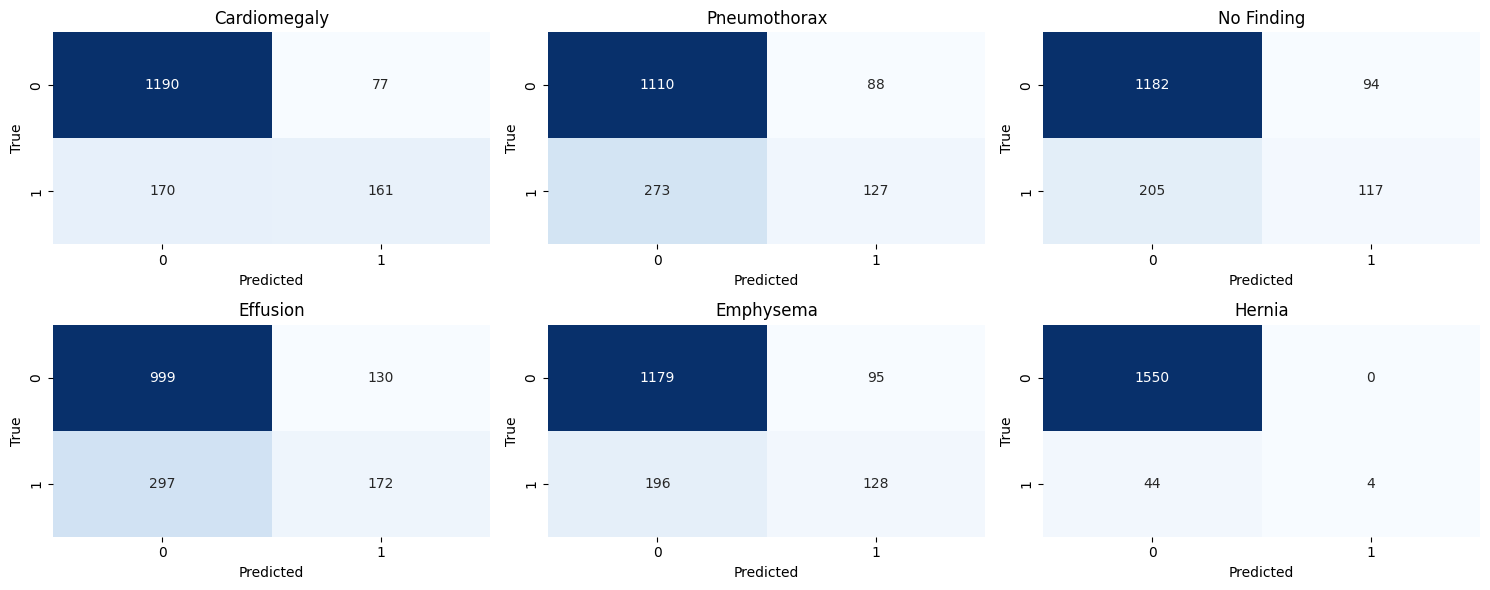


Classification Report:
              precision    recall  f1-score   support

Cardiomegaly       0.68      0.49      0.57       331
Pneumothorax       0.59      0.32      0.41       400
  No Finding       0.55      0.36      0.44       322
    Effusion       0.57      0.37      0.45       469
   Emphysema       0.57      0.40      0.47       324
      Hernia       1.00      0.08      0.15        48

   micro avg       0.59      0.37      0.46      1894
   macro avg       0.66      0.34      0.41      1894
weighted avg       0.60      0.37      0.46      1894
 samples avg       0.40      0.38      0.38      1894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print_confusion(true_labels, predicted_labels)

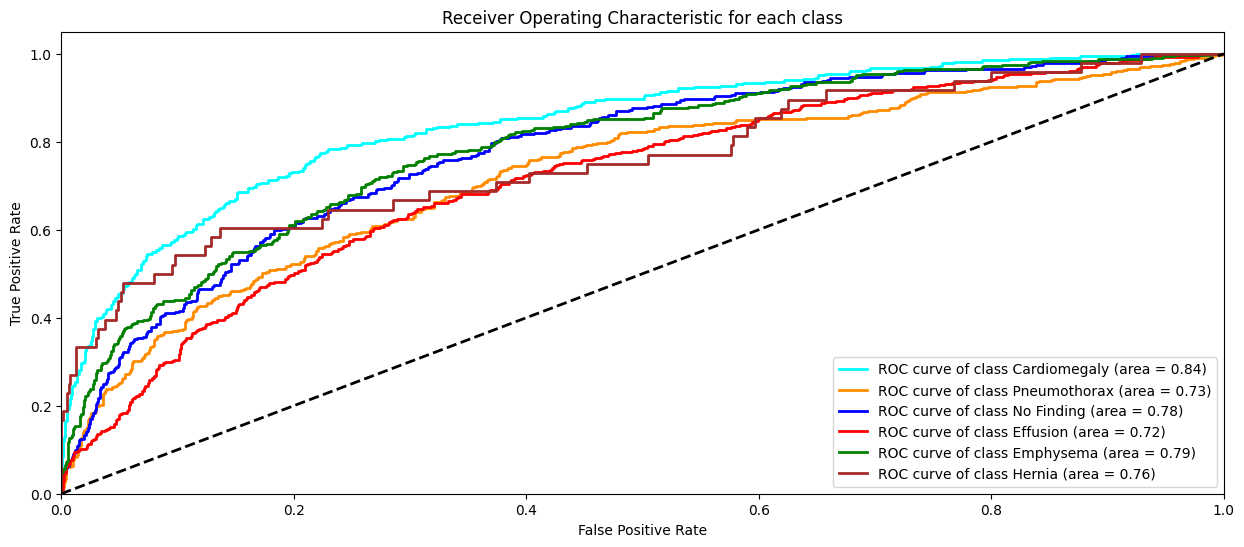

In [46]:
#Training Data support
print_ROC(true_labels, predicted_proba)

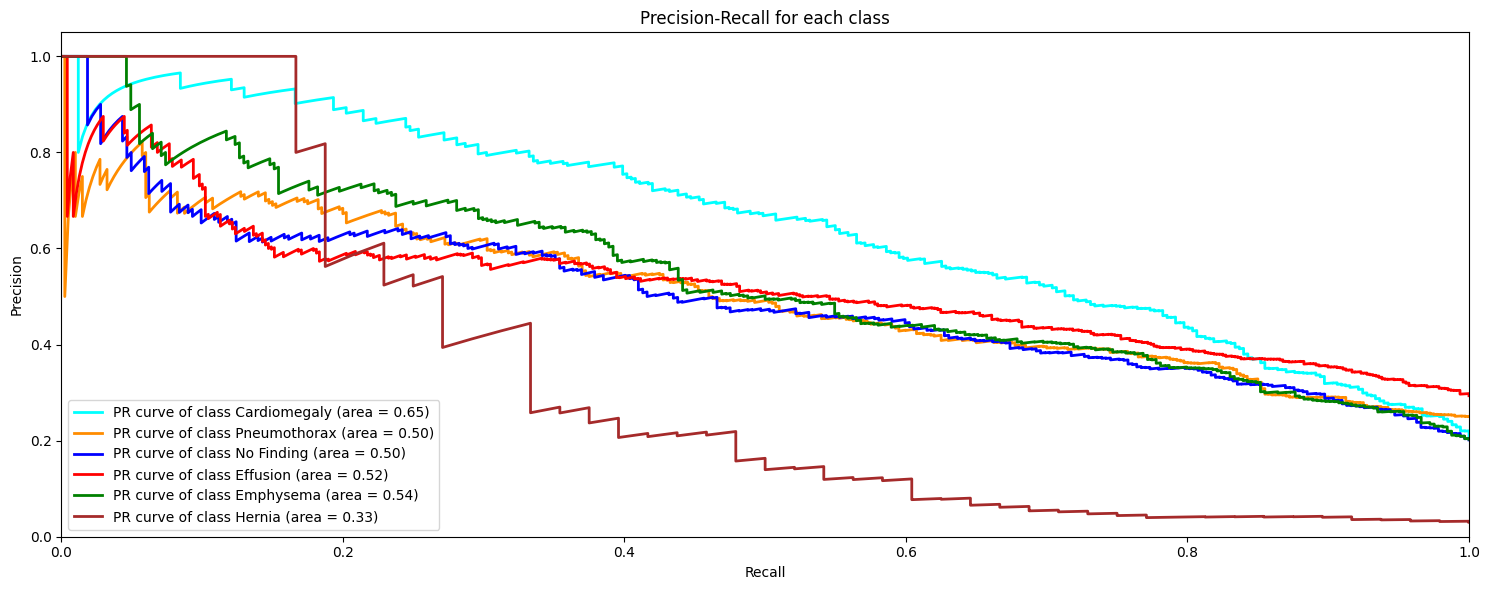

In [47]:
print_PR_curve(true_labels, predicted_proba)

In [48]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
true_labels, predicted_labels, predicted_proba = test_model(model_ft, test_dataloader, device, threshold = 0.1)

Accuracy: 0.2234
Precision: 0.4372
Recall: 0.6547
F1 Score: 0.5243


Multi-label Confusion Matrix:


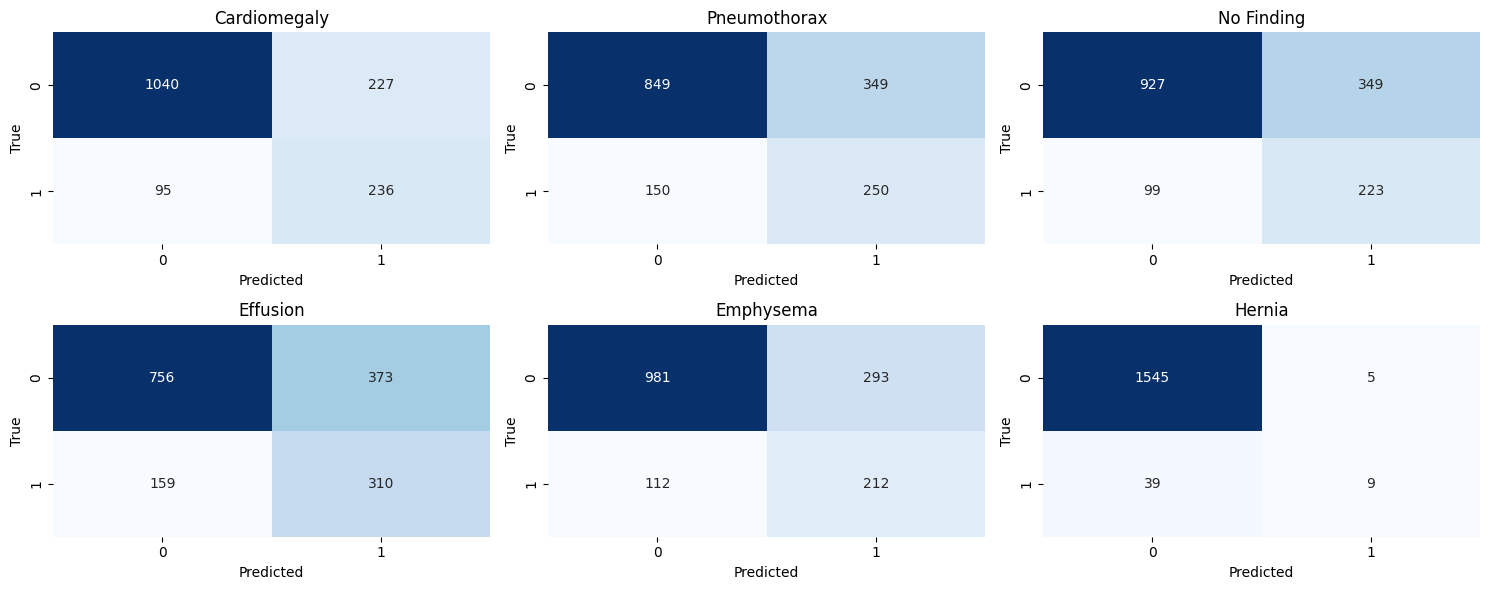


Classification Report:
              precision    recall  f1-score   support

Cardiomegaly       0.51      0.71      0.59       331
Pneumothorax       0.42      0.62      0.50       400
  No Finding       0.39      0.69      0.50       322
    Effusion       0.45      0.66      0.54       469
   Emphysema       0.42      0.65      0.51       324
      Hernia       0.64      0.19      0.29        48

   micro avg       0.44      0.65      0.52      1894
   macro avg       0.47      0.59      0.49      1894
weighted avg       0.44      0.65      0.52      1894
 samples avg       0.47      0.66      0.52      1894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
print_confusion(true_labels, predicted_labels)

In [50]:
true_labels, predicted_labels, predicted_proba = test_model(model_ft, test_dataloader, device, threshold =0.2)

Accuracy: 0.3254
Precision: 0.4978
Recall: 0.5438
F1 Score: 0.5198


Multi-label Confusion Matrix:


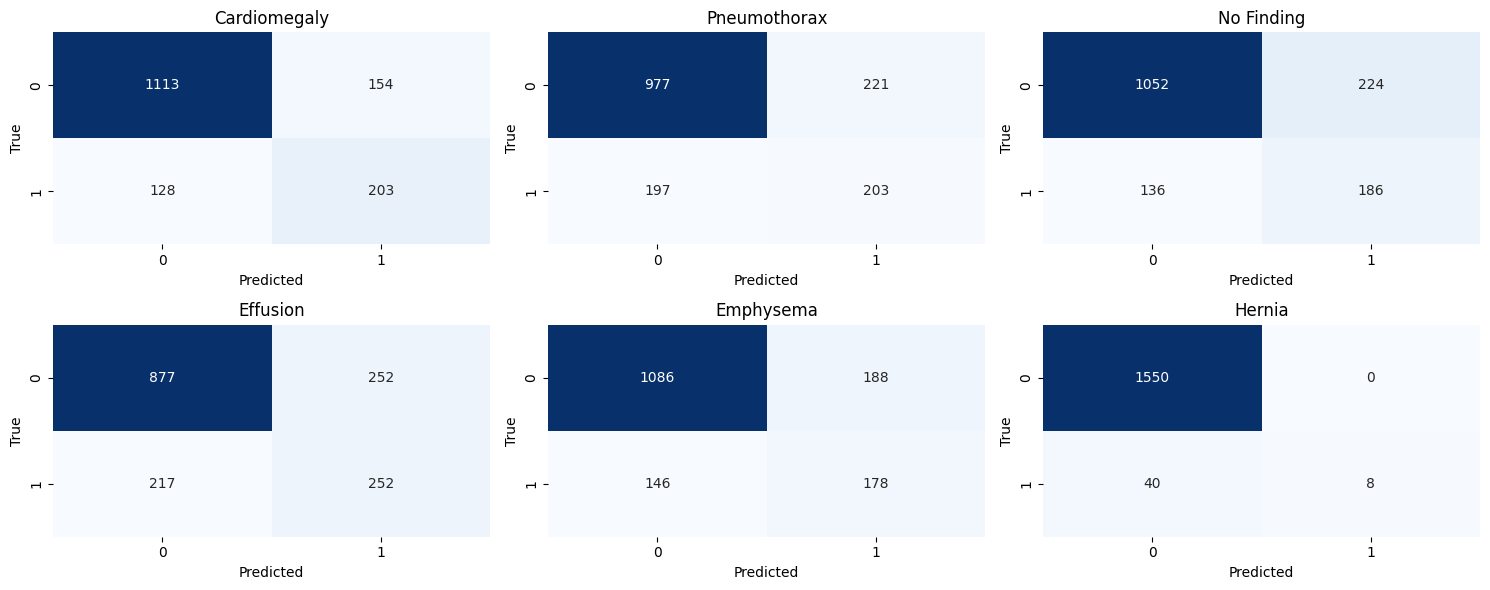


Classification Report:
              precision    recall  f1-score   support

Cardiomegaly       0.57      0.61      0.59       331
Pneumothorax       0.48      0.51      0.49       400
  No Finding       0.45      0.58      0.51       322
    Effusion       0.50      0.54      0.52       469
   Emphysema       0.49      0.55      0.52       324
      Hernia       1.00      0.17      0.29        48

   micro avg       0.50      0.54      0.52      1894
   macro avg       0.58      0.49      0.49      1894
weighted avg       0.51      0.54      0.52      1894
 samples avg       0.49      0.55      0.50      1894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print_confusion(true_labels, predicted_labels)

In [52]:
true_labels, predicted_labels, predicted_proba = test_model(model_ft, test_dataloader, device, threshold =0.3)

Accuracy: 0.3323
Precision: 0.5329
Recall: 0.4747
F1 Score: 0.5021


Multi-label Confusion Matrix:


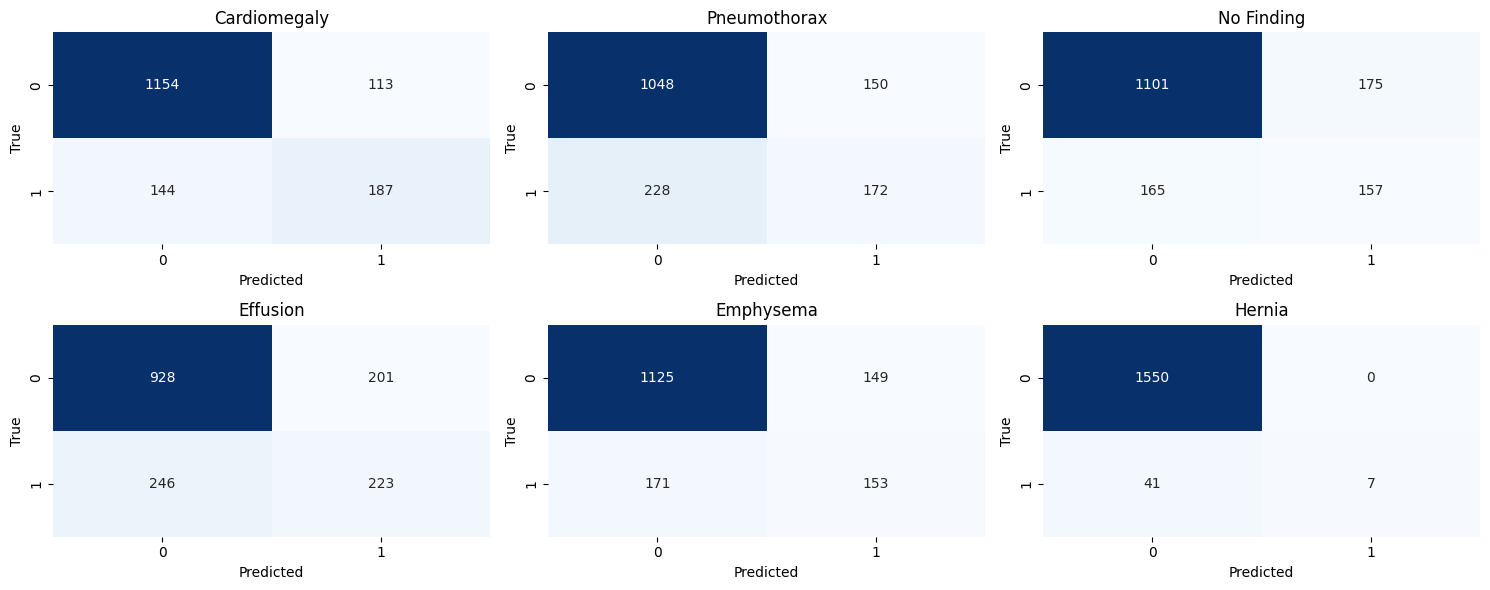


Classification Report:
              precision    recall  f1-score   support

Cardiomegaly       0.62      0.56      0.59       331
Pneumothorax       0.53      0.43      0.48       400
  No Finding       0.47      0.49      0.48       322
    Effusion       0.53      0.48      0.50       469
   Emphysema       0.51      0.47      0.49       324
      Hernia       1.00      0.15      0.25        48

   micro avg       0.53      0.47      0.50      1894
   macro avg       0.61      0.43      0.47      1894
weighted avg       0.54      0.47      0.50      1894
 samples avg       0.47      0.48      0.46      1894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
print_confusion(true_labels, predicted_labels)

In [54]:
true_labels, predicted_labels, predicted_proba = test_model(model_ft, test_dataloader, device, threshold =0.4)

Accuracy: 0.3129
Precision: 0.5623
Recall: 0.4240
F1 Score: 0.4834


Multi-label Confusion Matrix:


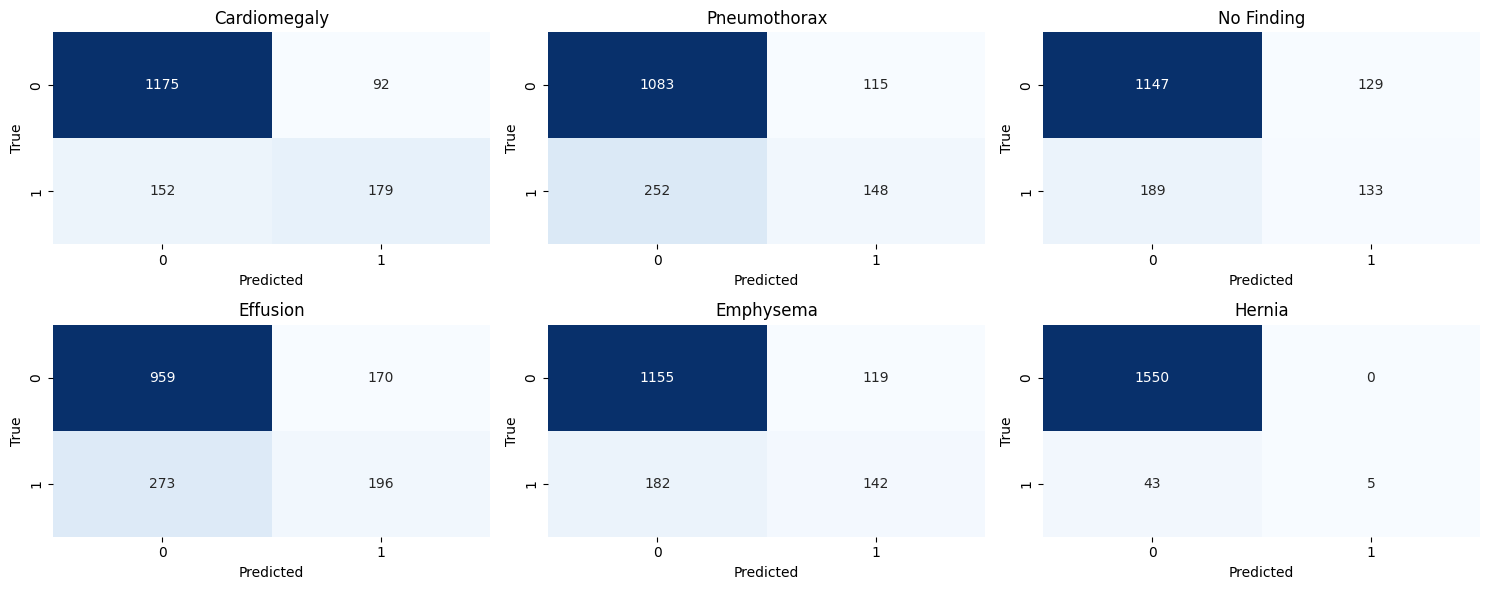


Classification Report:
              precision    recall  f1-score   support

Cardiomegaly       0.66      0.54      0.59       331
Pneumothorax       0.56      0.37      0.45       400
  No Finding       0.51      0.41      0.46       322
    Effusion       0.54      0.42      0.47       469
   Emphysema       0.54      0.44      0.49       324
      Hernia       1.00      0.10      0.19        48

   micro avg       0.56      0.42      0.48      1894
   macro avg       0.64      0.38      0.44      1894
weighted avg       0.57      0.42      0.48      1894
 samples avg       0.44      0.43      0.42      1894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print_confusion(true_labels, predicted_labels)